<h1 align="center">INFO621 - RAG Project RAG - XAI - PEFT Tuning [Mistral 7B - COLAB] </h1>



### This notebook / code was developed on COLAB - A100 GPU.

**This is a complementary notebook and Equivalent to the MISTRAL LOCAL (MACBook one). It is given as an alternative to execute the code on platform agnostic cloud env of COLAB** 
- Note some ablation experiments were done only Locally, so MISTRAL Local notebook has more content.


- Steps are mentioned in README.md.
    -  Execute the Next cell for pip installs. 
    -  This install all packages required on COLAB
    -  **Note : During package install, Colab would ask for "restart" of session. Please do so. And run the install cell again.**
    -  Requires access to your local google drive.
    -  Would need your HuggingFace Token (to download the models)

    -  change `local_path = ` below if you want to save Embedding model + Vector store in a different google drive mounted folder
    - We suggest running cell by cell manually to see the executions, as some steps are time consuming
  


#### Some steps take a long time to run, 
 - e.g. all the XAI frameworks may take few minutes to give results, RAGAS metrics are resource heavy.

### The code here uses Mistral-7B model for the E2E RAG pipeline + XAI + RAGAS evaluation
- Refer README.md for more details.
- And the Project report for combined study and analysis


### Core Libraries used in the project
 - **Core-ML/NLP**: torch, transformers, accelerate, bitsandbytes, sentence-transformers.
 - **Fine-Tuning**: peft, trl [PART OF ANOTHER NOTEBOOK]
 - **RAG & Vector Store**: langchain, chromadb, faiss-gpu
 - **Evaluation**: scikit-learn, **RAGAS**
 - **XAI**: captum, lime, shap, ,lit
 - **Data Handling**: datasets, numpy
 - **Utilities**: tqdm, psutil, asyncio, nest_asyncio, openai, tiktoken, matplotlib, seaborn

In [ ]:
# RUN FOR COLAB

!pip install seaborn==0.12.2
!pip install captum==0.8.0
# !pip install numpy==2.0.0
!pip install accelerate==1.6.0
!pip install sentence-transformers==3.4.1
!pip install langchain==0.3.24
!pip install langchain-community==0.3.23
!pip install langchainhub
!pip install chromadb==1.0.5
!pip install  scikit-learn

!pip install ragas==0.2.14
!pip install openai
!pip install nest_asyncio
!pip install shap==0.44.0
!pip install lime==0.2.0.1

!pip install -q lit-nlp
!pip install peft==0.8.2
!pip install trl==0.16.1
!pip install bitsandbytes
!pip install loralib

In [ ]:
#  Standard Library
import os
import re
import gc
import time
import asyncio
import warnings
from typing import List, Optional, Any
from collections import Counter

#  Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

#  Scientific & ML Libraries
import numpy as np
import torch
from torch.nn import functional as F
# import faiss
from tqdm import tqdm
import psutil
import shap
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

#  Transformers / HuggingFace
import accelerate
from transformers import (
    pipeline, AutoTokenizer, AutoModelForCausalLM,
    AutoModelForSeq2SeqLM, GenerationConfig, BitsAndBytesConfig
)
from sentence_transformers import SentenceTransformer
from captum.attr import Saliency, IntegratedGradients
from captum.attr import visualization as viz

#  LangChain Core
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.llms.base import LLM
from langchain.schema import LLMResult, Document
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.callbacks.manager import CallbackManager, CallbackManagerForLLMRun
from langchain.chat_models import ChatOpenAI
from langchain.schema.retriever import BaseRetriever

#  LangChain Community Extensions
# from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings


#  LangChain Core v1-style
from langchain_core.retrievers import BaseRetriever as LCBaseRetriever
from langchain_core.documents import Document as LCDocument
from langchain_core.pydantic_v1 import Field

#  RAGAS
from ragas import evaluate, EvaluationDataset
from ragas.run_config import RunConfig
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import BaseRagasEmbeddings, LangchainEmbeddingsWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness,
    AnswerCorrectness, ResponseRelevancy, ContextPrecision
)

#  Datasets
from datasets import Dataset, load_dataset

#  Notebook Setup
import nest_asyncio
nest_asyncio.apply()

#  Suppress Warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.")
warnings.filterwarnings("ignore", message="The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior")



In [ ]:
from langchain.callbacks.manager import CallbackManager

# Langchain callback for detailed logging
CALLBACK_VERBOSE_LOGGING=True



## ==== 1) Load FEVER Dataset ====

In [ ]:
dataset1 = load_dataset("copenlu/fever_gold_evidence")

In [ ]:
dataset1

In [ ]:
train = dataset1['train']
validation = dataset1['validation']
test = dataset1['test']

## ==== 2) Cleaned FEVER Dataset ====

####  For the preprocessing of the dataset we manage to remove:

- all words after the last dot (they don't belong to the sentence but are a kind of most relevant terms) ------> ?????
- all the digits that we found at the beginning of the sentence (also with the tab)
- all the parenthesis token strings
- all the words that contains characters that are not in ASCII format (for example the ones retrieved by the Wikipedia page for the pronunciation of a given name or term)
- all the punctuation


In [ ]:


# Special tokens like "-LRB-" etc.
PARENTHESIS_TOKENS = {"-LRB-", "-LSB-", "-RRB-", "-RSB-"}

# Check for non-ASCII characters
def contains_non_ascii(s):
    return any(ord(ch) > 127 for ch in s)

# Remove parenthesis tokens
def remove_parenthesis(sentence):
    return ' '.join([word for word in sentence.split() if word not in PARENTHESIS_TOKENS])

# Clean up a single sentence
def clean_sentence(sentence):
    if not isinstance(sentence, str):
        return ""

    # 1. Remove trailing fragments after first period (optional)
    sentence = re.sub(r'(\.[^.]*)$', '.', sentence)

    # 2. Remove leading digits + tab
    sentence = re.sub(r'^\d+\t', '', sentence)

    # 3. Remove special parenthesis tokens like -LRB-, -RRB-, etc.
    sentence = re.sub(r'-LRB-|-RRB-|-LSB-|-RSB-', '', sentence)

    # 4. Remove words with non-ASCII characters
    words = sentence.split()
    words = [word for word in words if all(ord(ch) < 128 for ch in word)]
    sentence = ' '.join(words)

    # 5. Remove punctuation and underscores but KEEP dots and commas
    sentence = re.sub(r'[^\w\s.,]', '', sentence)

    # 6. Normalize whitespace
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = re.sub(r'[^\w\s.,]', '', sentence)
    sentence = re.sub(r'[_]', ' ', sentence)

    # 7. Lowercase
    sentence = sentence.lower().strip()
    if not (sentence.endswith(".")):
        sentence +=  "."
    return sentence

In [ ]:
# === Extract and Clean Evidence Sentences ===
def clean_evidences(ds, max_len=500, typ="train"):
    evidence_sentences = []
    total = 0
    for example in ds:
        if 'evidence' in example and example['evidence']:
            total += 1
            for group in example['evidence']:
                full_sent = ""
                for ev in group:
                    if isinstance(ev, str) and not ev.isdigit():
                        sentence = clean_sentence(ev)
                        if sentence:
                            full_sent += sentence + " "
                if full_sent.strip():
                    evidence_sentences.append(full_sent.strip()[0:max_len])

    # Deduplicate
    evidence_sentences = list(set(evidence_sentences))
    print("total ", total)
    print(f"Total cleaned evidence dedup sentences : {len(evidence_sentences)}, of {typ}")
    for e in evidence_sentences[:2]:
        print("Sample:", e)
    return evidence_sentences

In [ ]:
# Use only 5,000 for our purpose.
train_10K=train.select(range(5000))
train_cl_10K = clean_evidences(train_10K)


In [ ]:
# Use 1000 for validation
validation_1K=validation.select(range(1000))
validation_cl_1K = clean_evidences(validation_1K, typ="validation")


In [ ]:
# Use 1000 for test
test_1K=test.select(range(1000))
test_cl_1K = clean_evidences(test_1K, typ="test")

## Pie Chart Code for Class Distribution

In [ ]:
from collections import Counter

# Count label distribution
label_counts = Counter([sample["label"] for sample in train_10K])

# Plot
labels = list(label_counts.keys())
sizes = list(label_counts.values())
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
# plt.axis("equal")
plt.title("Label Distribution in FEVER Train 5K Sample")
plt.show()

In [ ]:
# Count label distribution
label_counts = Counter([sample["label"] for sample in validation_1K])

# Plot
labels = list(label_counts.keys())
sizes = list(label_counts.values())
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
# plt.axis("equal")
plt.title("Label Distribution in FEVER Validate 1K Sample")
plt.show()

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
local_path = "/content/drive/MyDrive/models"


In [ ]:
# Login to HuggingFace
# !huggingface-cli login

# Or programatically
from huggingface_hub import login
login(token=" token id")

## === 3. Embedding Model ===

In [ ]:
def get_embedding_model(model_name: str = "BAAI/bge-m3", save_path: str = "./local_models/bge-m3"):
    """
    Downloads and saves a sentence-transformer model if not already saved.
    Returns a HuggingFaceEmbeddings instance for LangChain.

    Args:
        model_name (str): Name of the Hugging Face model.
        save_path (str): Local directory to save/load the model.

    Returns:
        HuggingFaceEmbeddings: Embedding wrapper usable with LangChain retrievers.
    """
    if not os.path.exists(save_path):
        print(f"Downloading and saving model '{model_name}' to: {save_path}.....")
        model = SentenceTransformer(model_name)

        model.save(save_path)
    else:
        print(f"Loading embedding model from local path: {save_path}...")

    model = HuggingFaceEmbeddings(model_name=save_path)
    sentence_transformer = SentenceTransformer(save_path)
    print(f"Successfully loaded Embed model.")
    return model, sentence_transformer

    # embeddings = HuggingFaceEmbeddings(model_name=model_name)
    # sentence_transformer = SentenceTransformer(model_name)
    # return embeddings, sentence_transformer

In [ ]:
embedding_model, sentence_transformer = get_embedding_model(
    model_name="BAAI/bge-m3",
    save_path= local_path + "/bge-m3"
)

## === 4. Chroma Vector Store ===



In [ ]:
def monitor_memory():
    mem = psutil.virtual_memory()
    return f"Memory used: {mem.used // (1024**2)} MB / {mem.total // (1024**2)} MB ({mem.percent}%)"

def get_or_create_chroma_db(texts, embedding_model, persist_dir, batch_size=100):
    if os.path.exists(persist_dir):
        print("Loading existing Chroma DB from disk...")
        return Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
    else:
        # return Chroma.from_texts(texts, embedding=embedding_model, persist_directory=persist_dir)
        print("Creating new Chroma DB and saving to disk...")
        print("given size ", len(texts))
        os.makedirs(persist_dir, exist_ok=True)

        # Create Chroma DB (empty)
        vectorstore = Chroma(embedding_function=embedding_model, persist_directory=persist_dir)

        for i in tqdm(range(0, len(texts), batch_size), desc="Indexing to Chroma"):
            batch = texts[i:i + batch_size]
            if batch:
                try:
                    vectorstore.add_texts(batch)
                    vectorstore.persist()  # flush to disk
                except Exception as e:
                    print(f"Skipped batch {i}: {e}")
                    raise
            gc.collect()  # clean up memory

        return vectorstore


In [ ]:
# TRAIN Chroma DB
evidence_sentences = train_cl_10K
vectorstore = get_or_create_chroma_db(
    texts=evidence_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_train1"
)
print (len(vectorstore))

In [ ]:
# VALIDATE Chroma DB
validation_sentences = validation_cl_1K
vectorstore_validate = get_or_create_chroma_db(
    texts=validation_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_validate"
)
print (len(validation_sentences))

###  The model

In [ ]:
def load_model(model_id="mistralai/Mistral-7B-Instruct-v0.2"):
    """
    Loads model from local directory if it exists,
    otherwise downloads and saves it to the specified path.

    Returns:
        tokenizer, model
    """
    print(f"Downloading model from Hugging Face: {model_id}...")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto")
    print(f"Successfully loaded model.")
    return tokenizer, model

In [ ]:
tokenizer, model = load_model()

In [ ]:
# Create a generation pipeline
gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=768, # TODO 1024 in colab
    pad_token_id=tokenizer.eos_token_id,  # this prevents the warning
    temperature=0.1,
    do_sample=True,
    top_p=0.95,
    # return_full_text=False
)

In [ ]:
# Wrap in LangChain LLM
llm = HuggingFacePipeline(pipeline=gen_pipeline)

### ===  DenseRetriever &  MultiQueryRetriever Setup ===



In [ ]:
# retriever = MultiQueryRetriever.from_llm(
#    retriever=vectorstore.as_retriever(search_kwargs={"k": 5}),
#    llm=llm # ChatOpenAI(temperature=0)  # Replace with HuggingFacePipeline if local-only
# )

# Dense retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})


In [ ]:
# Validate retriever
retriever_validate = vectorstore_validate.as_retriever(search_kwargs={"k": 5})

## === 6. Reasoning Prompt ===

In [ ]:

prompt_template = PromptTemplate.from_template("""
You are a classifier. Based ONLY on the evidence below, select the correct label for the claim:
SUPPORTS, REFUTES, or NOT ENOUGH INFO. Respond with only one word. If the claim entity is mentioned but no positive link exists, treat as REFUTES.

Claim: {question}

Evidence:
{context}

Your answer:
""")

# prompt_template = PromptTemplate.from_template("""
# Classify the following claim based on the provided evidence. Output only one of: SUPPORTS, REFUTES, NOT ENOUGH INFO.

# Claim: {question}
# Evidence: {context}

# Classification:
# """)

In [ ]:

def extract_label_from_answer_block(text):
    """
    Extracts the final label from the line after 'Your answer:' in the model's response.
    Assumes label is one of: SUPPORTS, REFUTES, NOT ENOUGH INFO
    """
    valid_labels = {"SUPPORTS", "REFUTES", "NOT ENOUGH INFO"}

    lines = text.strip().upper().splitlines()

    for i, line in enumerate(lines):
        if "YOUR ANSWER" in line:
            # Try next non-empty line
            for next_line in lines[i+1:]:
                candidate = next_line.strip(" .").upper()
                if candidate in valid_labels:
                    return candidate
                elif candidate:  # skip empty lines but stop if line has content
                    break
    return "UNKNOWN"


## === 7. RAG Chain ===

**Async Retrieval**
- Class that performs threshold-based evidence filtering for the RAG pipeline:
- Instead of naively using top 5 documents, it selects top K/5 which show cosine_simuilarity > threshold of 0.6
- 0.6 was empirically selected after doing analysis over 100s of claim outputs.
- Participates in end to end Chain Logging (retrival logging)

In [ ]:
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import LLMResult

class VerboseCallbackHandler(BaseCallbackHandler):
    """
    A detailed callback handler for monitoring and logging RAG pipeline steps, 
    including chain execution, retriever outputs, LLM prompts, LLM responses, 
    streaming tokens, and token usage.

    This handler is primarily used for debugging and analyzing pipeline behavior 
    by printing human-readable logs during retrieval, generation, and chain execution.

    Args:
        enabled (bool, optional): 
            Whether verbose logging is globally enabled. Defaults to True.
        
        print_prompt (bool, optional): 
            Whether to print LLM input prompts. Defaults to True.
        
        print_docs (bool, optional): 
            Whether to print retrieved documents' contents. Defaults to True.

    Attributes:
        enabled (bool): 
            Controls whether any logging is performed.
        
        print_prompt (bool): 
            Controls whether LLM prompts are displayed.
        
        print_docs (bool): 
            Controls whether retrieved documents are displayed.
        
        _timers (dict): 
            Internal dictionary to track timing information for different pipeline stages.

    """
    
    def __init__(self, enabled=True, print_prompt=True, print_docs=True):
        self.enabled = enabled
        self.print_prompt = print_prompt
        self.print_docs = print_docs
        self._timers = {}

    def _start_timer(self, key):
        self._timers[key] = time.time()
    
    def _end_timer(self, key):
        if key in self._timers:
            elapsed = time.time() - self._timers[key]
            print(f"⏱️ [Time] {key} took {elapsed:.2f} sec")
    
    def on_chain_start(self, serialized, inputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [Chain Start]")
        print(f"  ➤ Query: {inputs.get('query', inputs)}")
        self._start_timer("Chain")
        
    def on_chain_end(self, outputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("Chain")
        print(" [Chain End]")
        print(f"  ➤ Output: {outputs}")

    def on_retriever_end(self, documents, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print(f" [Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")

    def on_llm_start(self, serialized, prompts, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [LLM Prompt]")
        print(prompts[0][:1000])  # Truncate long prompts
        self._start_timer("LLM")
        
    def on_llm_end(self, response: LLMResult, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("LLM")            
        print("\n [LLM Response]")
        print(response.generations[0][0].text.strip())

    def on_llm_new_token(self, token: str, **kwargs):
        if CALLBACK_VERBOSE_LOGGING:
            print(token, end='', flush=True)

    def on_llm_end_streaming(self, **kwargs):
        if v:
            print()  # for clean newline after token stream

    def on_llm_token_usage(self, token_usage: dict, **kwargs):
        if  CALLBACK_VERBOSE_LOGGING:
            print(f"\n [Token Usage] prompt: {token_usage.get('prompt_tokens')}, "
                  f"completion: {token_usage.get('completion_tokens')}, "
                  f"total: {token_usage.get('total_tokens')}")
    
    def log_docs(self, documents):
        if not CALLBACK_VERBOSE_LOGGING: return
        print(f"[Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")            


#### Threshold Filtering Retriever
-  Extends the Retriever for RAGs and filters any documents having cosine similarity less than given threshold to offer more relevant and less documents to Model context

In [ ]:


from typing import List, Optional, Any
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import Field
from sklearn.metrics.pairwise import cosine_similarity
import time

class ThresholdFilteredRetriever(BaseRetriever):
    """
    A retriever that filters documents retrieved from a base retriever 
    based on a cosine similarity threshold using a query embedding.

    This retriever works by:
      1. Retrieving candidate documents using a base retriever.
      2. Computing embeddings for the query and documents.
      3. Filtering documents whose cosine similarity to the query 
         is below a specified threshold.
      4. Falling back to selecting top-k documents if no documents 
         pass the threshold.

    This improves retrieval precision by ensuring only semantically 
    relevant documents (above a threshold) are considered.

    Args:
        base_retriever (BaseRetriever): 
            The underlying retriever to fetch initial candidate documents.
        
        embedding_model (Any): 
            Embedding model providing `embed_query()` and `embed_documents()` 
            methods for vectorization.
        
        threshold (float, optional): 
            Minimum cosine similarity score to retain a document. Defaults to 0.65.
        
        fallback_topk (int, optional): 
            Number of top documents to fallback to if none meet the threshold. Defaults to 1.
        
        callback_handler (Optional[Any], optional): 
            Optional callback handler for logging document retrieval details.

    Attributes:
        total_queries (int): 
            Total number of queries processed.
        
        total_docs_returned (int): 
            Total number of documents returned across all queries.
        
        total_retrieval_time (float): 
            Total time spent on retrieval operations (in seconds).
    """
    
    base_retriever: Any = Field()
    embedding_model: Any = Field()
    threshold: float = Field(default=0.65)
    fallback_topk: int = Field(default=1)
    callback_handler: Optional[Any] = Field(default=None)

    total_queries: int = Field(default=0)
    total_docs_returned: int = Field(default=0)
    total_retrieval_time: float = Field(default=0.0)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        start = time.time()
        self.total_queries += 1
    
        # Support LCEL-wrapped retriever
        raw_docs = self.base_retriever.invoke(query)
        doc_texts = [doc.page_content for doc in raw_docs]
    
        if not doc_texts:
            return []
    
        query_emb = self.embedding_model.embed_query(query)
        doc_embs = self.embedding_model.embed_documents(doc_texts)
        sim_scores = cosine_similarity([query_emb], doc_embs)[0]
    
        filtered = [(raw_docs[i], sim_scores[i]) for i in range(len(raw_docs)) if sim_scores[i] >= self.threshold]
    
        if not filtered:
            sorted_docs = sorted(zip(raw_docs, sim_scores), key=lambda x: -x[1])
            filtered = sorted_docs[:self.fallback_topk]
    
        final_docs = [doc for doc, _ in filtered]
        self.total_docs_returned += len(final_docs)
        self.total_retrieval_time += (time.time() - start)
    
        if self.callback_handler:
            self.callback_handler.log_docs(final_docs)
    
        return final_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

    def print_metrics(self):
        if self.total_queries > 0:
            avg_time = self.total_retrieval_time / self.total_queries
            avg_docs = self.total_docs_returned / self.total_queries
        else:
            avg_time = avg_docs = 0
        print(f"\n Retrieval Metrics")
        print(f"  ➤ Total Queries: {self.total_queries}")
        print(f"  ➤ Avg Time per Query: {avg_time:.3f} sec")
        print(f"  ➤ Avg Docs Returned: {avg_docs:.2f}")



In [ ]:

callback = ConsoleCallbackHandler()

# Toggle logging
CALLBACK_VERBOSE_LOGGING=True

callback_handler = VerboseCallbackHandler(enabled=CALLBACK_VERBOSE_LOGGING)
callback_manager = CallbackManager([callback_handler])

# llm.callback_manager = callback_manager
retriever = retriever.with_config(callbacks=[callback_handler])
llm = llm.with_config(callbacks=[callback_handler])

# Wrap your retriever with threshold logic
filtered_retriever_train = ThresholdFilteredRetriever(
    base_retriever=retriever,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler
)

tagged_rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=filtered_retriever_train,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template},
    callbacks=[callback_handler],  #  Add callback
    verbose=False
)

In [ ]:
filtered_retriever_validate = ThresholdFilteredRetriever(
    base_retriever=retriever_validate,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler
)


tagged_rag_chain_validate = RetrievalQA.from_chain_type(
	    llm=llm,
	    retriever=filtered_retriever_validate,
	    chain_type="stuff",
	    return_source_documents=True,
	    chain_type_kwargs={"prompt": prompt_template}
)

In [ ]:
gc.collect()
CALLBACK_VERBOSE_LOGGING=False

### Compare Async Vs Sync Retrieval from Vector DB

In [ ]:
# import time, asyncio

# import nest_asyncio
# nest_asyncio.apply()

# claims = [train_10K[i]['claim'] for i in range(5)]  # your 100 claims

# # Sync
# start = time.time()
# sync_results = [tagged_rag_chain.invoke({"query": c}) for c in claims]
# sync_time = time.time() - start
# print(f"⏱️ Sync: {sync_time:.2f} sec")

# # ASYNC
# async def run_async_batch():
#     tasks = [tagged_rag_chain.ainvoke({"query": c}) for c in claims]
#     return await asyncio.gather(*tasks)

# start = time.time()
# async_results = await run_async_batch()  # ✅ for Jupyter
# async_time = time.time() - start
# print(f"⚡ Async: {time.time() - start:.2f} sec")


In [ ]:

# # Bar chart setup
# methods = ['Sync', 'Async']
# times = [sync_time, async_time]

# plt.figure(figsize=(8, 5))
# bars = plt.bar(methods, times, color=["steelblue", "mediumseagreen"])
# plt.title("Sync vs Async Retrieval + Generation Time")
# plt.ylabel("Time (seconds)")
# plt.xlabel("Execution Method")

# # Annotate bars neatly above center
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f"{yval:.1f}s", ha='center', va='bottom')

# plt.ylim(0, max(times) + 1)
# plt.tight_layout()
# plt.show()


###  EXECUTION on one Claim

In [ ]:
# Run just one sample for explainability
CALLBACK_VERBOSE_LOGGING=True
sample = train_10K[200]
claim = sample['claim']
result = tagged_rag_chain({"query": claim})
documents = result['source_documents']
doc_texts = [doc.page_content for doc in documents]


In [ ]:
# print(result['source_documents'])
generated_answers=[result['result']]

In [ ]:
pred_label = extract_label_from_answer_block(result["result"])
print("actual=",sample['label'],", predicted=",pred_label)

In [ ]:
# Turn OFF the DETAILED LLM Chain LOGGING
CALLBACK_VERBOSE_LOGGING=False

# === 9 a). Explainable AI (Captum Saliency) ===

In [ ]:
def build_input_text_with_evidence(claim, doc_texts, tokenizer, max_tokens=512):
    """
    Safely build a prompt including the claim and as many evidence chunks as fit within max_tokens.

    Args:
        claim (str): The claim string.
        doc_texts (list): List of evidence strings.
        tokenizer: HuggingFace tokenizer to count tokens.
        max_tokens (int): Max allowed token length (for Mistral, keep ≤ 2048, safer ~512-1024).

    Returns:
        str: Truncated prompt with claim + partial evidence.
    """
    header = f""
    current_token_count = len(tokenizer.encode(header))

    included_evidence = []

    for i, doc in enumerate(doc_texts):
        entry = f"{i+1}. {doc.strip()}\n"
        tokens = len(tokenizer.encode(entry))
        if current_token_count + tokens <= max_tokens:
            included_evidence.append(entry)
            current_token_count += tokens
        else:
            break

    return header + "".join(included_evidence)

In [ ]:
# model.eval()

label_token = pred_label  # or REFUTED, etc.

context = build_input_text_with_evidence(claim, doc_texts, max_tokens=512, tokenizer=tokenizer)
input_text = prompt_template.format(question=claim, context=context)

# Tokenize input
inputs = tokenizer(input_text, return_tensors="pt")
input_ids = inputs["input_ids"].to(model.device)
attention_mask = inputs["attention_mask"].to(model.device)


# Get input embeddings for Captum
input_embeddings = model.get_input_embeddings()(input_ids)
input_embeddings.requires_grad_()

# Token ID of predicted label
label_token_id = tokenizer(pred_label, add_special_tokens=False)["input_ids"][0]
print(label_token_id)

# === 3. Define a forward function that returns scalar logit for predicted label ===

def forward_func(embeddings):
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    return outputs.logits[:, -1, label_token_id]  # Attribution at position the model starts generating


In [ ]:
ig = IntegratedGradients(forward_func)
attributions, delta = ig.attribute(input_embeddings,
                            internal_batch_size=1,
                            return_convergence_delta=True,
                            n_steps=30) # TODO : make it 20 or 30 for COLAB

In [ ]:
# Normalize and summarize
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    return attributions / torch.norm(attributions)

summarized = summarize_attributions(attributions)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = summarized.detach().cpu().to(torch.float32).numpy()

# Pair tokens and scores, sort
token_score_pairs = list(zip(tokens, scores))
sorted_pairs = sorted(token_score_pairs, key=lambda x: x[1], reverse=True)


In [ ]:
def merge_tokens_and_scores(tokens, scores):
    merged = []
    current_word = ""
    current_score = 0.0
    count = 0

    for tok, score in zip(tokens, scores):
        if tok.startswith("▁"):  # New word
            if current_word:
                merged.append((current_word, current_score / count))
            current_word = tok[1:]
            current_score = score
            count = 1
        else:
            current_word += tok
            current_score += score
            count += 1

    if current_word:
        merged.append((current_word, current_score / count))

    return sorted(merged, key=lambda x: x[1], reverse=True)

merged_words = merge_tokens_and_scores(tokens, scores)
# for word, score in merged_words[:50]:
#     print(f"{word:50s} : {score:.4f}")

# Plot
# Take top 20 words by attribution score
top_words = merged_words[:30]
words, word_scores = zip(*top_words)

# Plot
plt.figure(figsize=(10, 10))
plt.barh(words[2:][::-1], word_scores[2:][::-1])
plt.xlabel("Attribution Score")
plt.title("Top 30 Influential Words (Captum Attribution)")
plt.tight_layout()
plt.show()

### Heatmap of top token attributions

In [ ]:
from IPython.display import display, HTML
def normalize_percentile(scores, low=2, high=98):
    arr = np.array(scores)
    vmin = np.percentile(arr, low)
    vmax = np.percentile(arr, high)
    vmax = max(vmax, vmin + 1e-6)  # prevent divide-by-zero
    return arr, vmin, vmax

def highlight_tokens_colored(merged_words, cmap=matplotlib.cm.coolwarm, use_percentile=True):
    raw_scores = [score for _, score in merged_words]

    if use_percentile:
        scores, vmin, vmax = normalize_percentile(raw_scores)
    else:
        scores = np.array(raw_scores)
        vmin, vmax = min(scores), max(scores) + 1e-6

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    html = ""
    for (word, _), score in zip(merged_words, scores):
        rgba = cmap(norm(score))
        r, g, b, _ = [int(x * 255) for x in rgba]
        html += f'<span style="background-color: rgba({r},{g},{b}, 0.6); padding:2px; margin:1px;">{word}</span> '

    display(HTML(f"<div style='font-family:monospace; line-height:1.6;'>{html}</div>"))

highlight_tokens_colored(merged_words)

In [ ]:
from captum.attr import visualization as viz
tokens = tokens[:100]
scores = scores[:100]

record = viz.VisualizationDataRecord(
    scores,                 # word_attributions
    0.0,                    # pred_prob
    pred_label,            # pred_class
    sample['label'],            # true_class
   sample['label'],            # attr_class
    scores.sum(),           # attr_score
    tokens,                 # raw_input (tokens as list)
    delta.item()                       # convergence_score (use 0 if not IG)
)

viz.visualize_text([record])

#### Insights 
 - Model Decision: The model accurately classified the claim ("Suicide Kings is a film from the United States.") as "SUPPORTS" based on provided evidence ("Suicide Kings is a 1997 American mystery crime film...").

- Attribution Insights (Captum):

     - The words "film," "suicide," "Kings," and "1997" have significant positive contributions, indicating they strongly influenced the classification decision.

     - The visualization and heatmap clearly show the word "film" as the most influential feature, with the highest attribution score.

- Token-Level Visualization:

  - The Captum text visualization further confirms "film," "suicide," and "Kings" as critical tokens for classification, aligning well with the intended logical reasoning process of the classifier.

**In summary**, Captum's attribution techniques successfully highlighted critical evidence tokens contributing to the accurate claim verification by the model.

### Limitations of Captum - Mistral integration
Due to model size, attributions are computed over truncated context of top-ranked evidence chunks”
- Further with limited n_steps=30 in the IntegratedGradients(...)
- Mistral (and most LLMs) heavily weight boilerplate like "Your answer:", and "the" especially if seen frequently during training.

##  === 9 b). Explainable AI - SHAP for XAI - Does not Integrate with MISTRAL

In [ ]:
import shap

def extract_final_label(text):
    """
    Extracts the final classification word from model output.
    Returns one of: SUPPORTS, REFUTES, NOT ENOUGH INFO, or UNKNOWN
    """
    valid_labels = {"SUPPORTS", "REFUTES", "NOT ENOUGH INFO"}

    # Search for the last valid label after "YOUR ANSWER:"
    match = re.search(r"YOUR ANSWER:\s*(SUPPORTS|REFUTES|NOT ENOUGH INFO)\b", text.upper())

    if match:
        return match.group(1)
    return "UNKNOWN"


def qwen2_predict(texts):
    # Make sure each input is converted to plain Python string

    str_inputs = [str(t) for t in texts]
    # print(str_inputs)
    results = gen_pipeline(str_inputs, max_new_tokens=30)
    # print(results)
    outputs = []
    for res in results:
        t = res[0]["generated_text"].upper()
        output_text = extract_final_label(t)
        if "SUPPORTS" in output_text:
            outputs.append([1, 0, 0])
        elif "REFUTES" in output_text:
            outputs.append([0, 1, 0])
        else:
            outputs.append([0, 0, 1])
    return np.array(outputs)



In [ ]:

explainer = shap.Explainer(qwen2_predict, tokenizer)
shap_values = explainer([prompt_template.format(question=claim, context = doc_texts[0])])
shap.plots.text(shap_values[0])  # Visual heatmap

#### Insights 
 - Model Decision: The model accurately classified the claim ("Suicide Kings is a film from the United States.") as "SUPPORTS" based on provided evidence ("Suicide Kings is a 1997 American mystery crime film...").

- Attribution Insights (Captum):

     - The words "film," "suicide," "Kings," and "1997" have significant positive contributions, indicating they strongly influenced the classification decision.

     - The visualization and heatmap clearly show the word "film" as the most influential feature, with the highest attribution score.

- Token-Level Visualization:

  - The Captum text visualization further confirms "film," "suicide," and "Kings" as critical tokens for classification, aligning well with the intended logical reasoning process of the classifier.

**In summary**, Captum's attribution techniques successfully highlighted critical evidence tokens contributing to the accurate claim verification by the model.

### Limitations of Captum - Mistral integration
Due to model size, attributions are computed over truncated context of top-ranked evidence chunks”
- Further with limited n_steps=30 in the IntegratedGradients(...)
- Mistral (and most LLMs) heavily weight boilerplate like "Your answer:", and "the" especially if seen frequently during training.

##  === 9 c). Explainable AI - LIME Integration ===

In [ ]:
from lime.lime_text import LimeTextExplainer

def lime_predict(texts):
    outputs = []
    for text in texts:
        result = gen_pipeline(text, max_new_tokens=512)[0]['generated_text']
        lb = extract_label_from_answer_block(result)
        if "SUPPORTS" in sample['label']:
            outputs.append([1, 0, 0])
        elif "REFUTES" in sample['label']:
            outputs.append([0, 1, 0])
        else:
            outputs.append([0, 0, 1])
    return np.array(outputs)

In [ ]:
inp= f"SUPPORTS, REFUTES, or NOT ENOUGH INFO. Give one word asnwer? Claim: {claim}\nEvidence:\n" + "\n".join(doc_texts)
class_names = ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(
    # prompt_template.format(
    #     question=claim,
    #     context="\n".join(doc_texts)
    # ),
    inp,
    lime_predict,
    num_features=25,
    num_samples=3
)
exp.show_in_notebook(text=True)

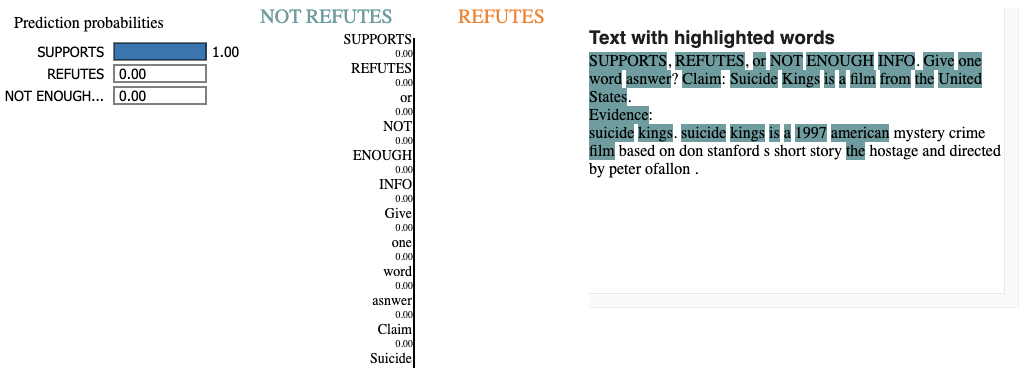

**Insights**
- LIME correctly highlights factually relevant tokens:
   - "suicide kings", "1997", "american", "crime film", "based on"
- These are key evidence tokens that support the claim "Suicide Kings is a film from the United States."
- All other probabilities are shown as 0 — possibly a rounding/rendering issue).
- The focus is on "Claim" and "Evidence" content — exactly what we want.


###  === 9 d). Explainable AI --  LangChain Callbacks: Full Pipeline Logging ===

**Below we showcase complete Rag chain pipeline tracing**
- From retriever, to evidence collected, and LLM decision
- Time logged at each stage

In [ ]:
CALLBACK_VERBOSE_LOGGING=True
sample = train_10K[201]
claim = sample['claim']
result = tagged_rag_chain({"query": claim})
print("label=",sample['label'])
CALLBACK_VERBOSE_LOGGING=False

## === Explanable AI - LIT (Language Interpretability Tool) ===

In [ ]:
# !pip install -U git+https://github.com/PAIR-code/lit.git@main#egg=lit-nlp
# !pip install --upgrade lit-nlp

### We tried LIT, but it has limited Notebook support

In [ ]:
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types
from lit_nlp.api import dataset as lit_dataset
from lit_nlp import notebook

# 1. Define your LLM wrapper
class MistralWrapper(lit_model.Model):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def predict(self, inputs):
        outputs = []
        for ex in inputs:
            response = self.pipeline(ex['text'], max_new_tokens=64)[0]["generated_text"]
            outputs.append({"prediction": response})
        return outputs

    def input_spec(self):
        return {"text": lit_types.TextSegment()}

    def output_spec(self):
        return {"prediction": lit_types.GeneratedText()}

# 2. Define your dataset
class FEVERDataset(lit_dataset.Dataset):
    """LIT-compatible Dataset for FEVER claims."""

    def __init__(self, examples):
        """
        Args:
            examples: List of dicts, each with at least {'claim', 'label'}.
        """
        self._examples = []
        for ex in examples:
            self._examples.append({
                "text": ex["claim"],
                "label": ex["label"],
                # Optional if you have evidence:
                "evidence": ex.get("label", ""),
            })

    def __len__(self):
        return len(self._examples)

    def __getitem__(self, i):
        return self._examples[i]

    def spec(self):
        """Field specification for LIT UI."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(vocab=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]),
            # Optional:
            "evidence": lit_types.TextSegment(),
        }

# 3. Initialize model and dataset
model = MistralWrapper(gen_pipeline)
data = FEVERDataset(train.select(range(5)))

lit_widget = notebook.LitWidget(models={"mistral": model}, datasets={"fever": data})
lit_widget.render()


# PUT A SCRREENSHOT FROM COLAB OUTPUT

# == RAG Evaluation and Metrices ==

##  Evaluate ACCURACY : Model with RAG VS without RAG

#### With RAG.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_rag_chain_accuracy(claim_dataset, rag_chain, label_field="label", num_samples=1000):
    """
    Evaluates the RAG chain on a dataset of claims.

    Args:
        claim_dataset: HuggingFace Dataset or list of dicts with 'claim' and 'label'
        rag_chain: LangChain RetrievalQA object
        label_field: field containing true label (default: "label")
        num_samples: number of claims to evaluate

    Returns:
        pred_labels, true_labels
    """

    true_labels = []
    pred_labels = []

    for sample in tqdm(claim_dataset.select(range(num_samples)), desc="Evaluating RAG", ncols=100):
        claim = sample["claim"]
        true_label = sample[label_field].upper()

        try:
            result = rag_chain({"query": claim})
            model_output = result["result"]
            pred_label = extract_label_from_answer_block(model_output)
        except Exception as e:
            print(f" Error for claim: {claim[:50]}... | {str(e)}")
            pred_label = "UNKNOWN"

        true_labels.append(true_label)
        pred_labels.append(pred_label)

    # Evaluation
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"\n Accuracy: {accuracy:.4f}")
    print("\n Classification Report:\n", classification_report(true_labels, pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"],
                yticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"], cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return pred_labels, true_labels


In [ ]:
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate, num_samples=200)


#### Without RAG.

In [ ]:

# --- Load Dataset (100 claims) ---
eval_subset = validation.select(range(100))

# --- Prompt Template ---
prompt_template_temp = """You are a fact-checking assistant.
Given a claim, classify it as one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO. Do not give reasoning.

Claim: {claim}

Your answer:
"""

# prompt = prompt_template_temp.format(claim=eval_subset[0]['claim'])
# print(prompt)
# response = gen_pipeline(prompt, do_sample=False)[0]['generated_text'].upper()
# response

In [ ]:

# --- Evaluation Lists ---
true_labels_wp = []
pred_labels_wo = []

# --- TQDM Loop ---
for sample in tqdm(eval_subset, desc="Evaluating without RAG", unit="sample"):
    claim = sample['claim']
    true_label = sample['label'].upper()

    prompt = prompt_template_temp.format(claim=claim)
    response = gen_pipeline(prompt, do_sample=False)[0]['generated_text'].upper()

    pred_label = extract_label_from_answer_block(response)

    true_labels_wp.append(true_label)
    pred_labels_wo.append(pred_label)

# --- Evaluation ---
accuracy = accuracy_score(true_labels_wp, pred_labels_wo)
print(f"\nAccuracy: {accuracy:.4f}")
print("\n Classification Report:\n", classification_report(true_labels_wp, pred_labels_wo))

# --- Confusion Matrix ---
labels = ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]
cm = confusion_matrix(true_labels_wp, pred_labels_wo, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (LLM w/o RAG)")
plt.show()


## === Visualizations ===

#### Aggregate Average Similarity Across All Claims : How well retriever is doing ?

In [ ]:
# Compute cosine similarity between each claim and its top-k retrieved evidences, then average the similarity scores across samples.

similarity_matrix = []

for sample in train.select(range(10)):
    claim = sample['claim']
    result = tagged_rag_chain({"query": claim})
    evidence_texts = [doc.page_content for doc in result['source_documents']]

    if not evidence_texts:
        continue  # skip if no retrieved docs

    claim_emb = embedding_model.embed_query(claim)
    evidence_embs = embedding_model.embed_documents(evidence_texts)

    sim_scores = cosine_similarity([claim_emb], evidence_embs)[0]  # shape (top_k,)
    similarity_matrix.append(sim_scores)

# Convert to numpy and pad to same length if needed
max_k = max(len(row) for row in similarity_matrix)
padded_matrix = np.array([np.pad(row, (0, max_k - len(row))) for row in similarity_matrix])
avg_scores = np.mean(padded_matrix, axis=0)

# Plot average similarity
sns.heatmap([avg_scores], annot=True, cmap="YlGnBu")
plt.xlabel("Evidence Index")
plt.title("Average Claim-Evidence Similarity (10 Claims)")
plt.show()

**What it shows**
- The top evidence (index 0) is aligned with claim (0.71). This is quite relevant
- Retriever is doing a good job for the top 1 or 2, but recall could be improved at rank 3–5

### Pie Chart for Prediction Label Distribution for RAG based output

In [ ]:
from collections import Counter
label_counts = Counter(pred_labels)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Model Prediction Distribution")
plt.axis('equal')
plt.show()


### True vs Predicted Label Distribution for RAG based output

In [ ]:
# Count frequencies
true_counts = Counter(true_labels)
pred_counts = Counter(pred_labels)

# Ensure consistent label order
all_labels = sorted(list(set(true_counts.keys()) | set(pred_counts.keys())))

true_values = [true_counts.get(label, 0) for label in all_labels]
pred_values = [pred_counts.get(label, 0) for label in all_labels]

# Bar plot setup
x = np.arange(len(all_labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, true_values, width, label="True Labels")
plt.bar(x + width/2, pred_values, width, label="Predicted Labels")

plt.ylabel("Count")
plt.title("True vs Predicted Label Distribution")
plt.xticks(x, all_labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()


### Refer Project report for Analysis
- Mistral-7B model performed poorly, especially on the Refutes class (recall = 0.07), indicating over-reliance on the Supports & NEI label.

## ===== RAG statistics via RAGAS ======

- Since it takes a long time, we evaluate only a few claims to get the RAGAS metrics


In [ ]:
class RAGASLLM(LLM):
    tokenizer: AutoTokenizer = None
    model: AutoModelForCausalLM = None

    def __init__(self, _model, tokenizer):
        super().__init__()
        self.model = _model
        self.tokenizer = tokenizer

    def _call(self, prompt: str, stop: Optional[List[str]] = None,
              run_manager: Optional[CallbackManagerForLLMRun] = None, **kwargs: Any) -> str:
        messages = [{"role": "user", "content": prompt}]
        input_ids = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.tokenizer([input_ids], return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(inputs.input_ids, max_new_tokens=512)
        generated = outputs[:, inputs.input_ids.shape[-1]:]
        decoded = self.tokenizer.decode(generated[0], skip_special_tokens=True)
        # print(decoded)
        return decoded

    @property
    def _llm_type(self) -> str:
        return "Mistral-7B"


In [ ]:
class RagasEmbedding(BaseRagasEmbeddings):
    def __init__(self, sentence_model, batch_size=256):
        self.model = sentence_model
        self.batch_size = batch_size

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.model.encode(texts, batch_size=self.batch_size, show_progress_bar=False).tolist()

    def embed_query(self, text: str) -> List[float]:
        return self.model.encode([text], show_progress_bar=False)[0].tolist()

    async def aembed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.embed_documents(texts)

    async def aembed_query(self, text: str) -> List[float]:
        return self.embed_query(text)

In [ ]:


def generate_ragas_dataset(rag_chain, dataset, num_samples=100, start_idx=0, verbose=True):
    """
    Generate a RAGAS-compatible Dataset from a LangChain RAG pipeline.

    Args:
        rag_chain: LangChain RetrievalQA or custom RAG chain.
        dataset: HuggingFace Dataset (or list of dicts) with 'claim' and 'label' fields.
        num_samples: Number of samples to generate (default: 100).
        start_idx: Index to start from in the dataset (default: 0).
        verbose: Whether to print progress/errors (default: True).

    Returns:
        A HuggingFace Dataset compatible with RAGAS evaluation.
    """

    questions = []
    answers = []
    contexts_list = []
    ground_truths = []

    selected_data = dataset.select(range(start_idx, start_idx + num_samples))
    done = 0
    for sample in selected_data:
        claim = sample['claim']
        actual_label = sample['label']

        try:
            result = rag_chain({"query": claim})
            model_answer = result['result']
            doc_texts = [doc.page_content for doc in result['source_documents']]

            # Append to lists
            questions.append(claim)
            answers.append(model_answer)
            contexts_list.append(doc_texts)
            ground_truths.append(actual_label)
            print(f"Progress: {done + 1} / {num_samples}", end="\r", flush=True)
            done += 1
        except Exception as e:
            if verbose:
                print(f" Error on sample: {claim[:30]}... → {str(e)}")

    # Convert to HuggingFace Dataset
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts_list,
        "ground_truth": ground_truths
    }

    return Dataset.from_dict(data)



In [ ]:

ragas_dataset = generate_ragas_dataset(
    rag_chain=tagged_rag_chain,
    dataset=train,
    num_samples=3,      # how many claims to run
    start_idx=0,          # from where in dataset
    verbose=True          # print errors if any
)

In [ ]:
run_config = RunConfig(timeout=800, max_wait=800)

ragas_embedding_model = RagasEmbedding(sentence_transformer)
ragas_llm = LangchainLLMWrapper(RAGASLLM(model, tokenizer), run_config)

ragas_result = evaluate(
    dataset=ragas_dataset,
    metrics=[
        LLMContextRecall(),
        ContextPrecision(),
        Faithfulness(),
        AnswerCorrectness(),
        ResponseRelevancy(),
        FactualCorrectness()
    ],
    llm=ragas_llm,
    embeddings=ragas_embedding_model,
    run_config=run_config
)



In [ ]:
# Average across samples
ragas_result

In [ ]:
print(ragas_result.to_pandas())

In [ ]:
ragas_result.to_pandas()

#### RAGAS :  saliency heatmap per question

In [ ]:
for idx, row in enumerate(ragas_dataset):

    print(f"=== Question {idx}: {row['question']} ===")

    # Get Faithfulness and Context Recall score for this example
    faithfulness_score = ragas_result['faithfulness'][idx]
    context_recall_score = ragas_result['context_recall'][idx]

    print(f"Faithfulness Score: {faithfulness_score:.4f}")
    print(f"Context Recall Score: {context_recall_score:.4f}")

    # Retrieved contexts for this question
    retrieved_chunks = row['contexts']

    # Build dummy "saliency" score for each context (for now, equal scores)
    # Later you can replace this with better logic
    chunk_saliency = [1/len(retrieved_chunks)] * len(retrieved_chunks)

    # Plotting the saliency
    fig, ax = plt.subplots(figsize=(8, 0.5 * len(retrieved_chunks)))

    ax.barh(
        y=[f"Doc {i+1}" for i in range(len(retrieved_chunks))],
        width=chunk_saliency,
        color='skyblue'
    )

    ax.set_xlabel("Attribution Score")
    ax.set_title(f"Retrieval Saliency Heatmap for Question {idx}")
    plt.gca().invert_yaxis()  # Doc 1 on top

    plt.show()

    print("-" * 80)

## Now Run RAGAS on 25 samples --- Base Mistral Model


In [ ]:

ragas_dataset = generate_ragas_dataset(
    rag_chain=tagged_rag_chain,
    dataset=train,
    num_samples=25,      # how many claims to run
    start_idx=0,          # from where in dataset
    verbose=True          # print errors if any
)

In [ ]:
run_config = RunConfig(timeout=800, max_wait=800)

ragas_embedding_model = RagasEmbedding(sentence_transformer)
ragas_llm = LangchainLLMWrapper(RAGASLLM(model, tokenizer), run_config)

ragas_result_25 = evaluate(
    dataset=ragas_dataset,
    metrics=[
        Faithfulness(),
        ResponseRelevancy()
    ],
    llm=ragas_llm,
    embeddings=ragas_embedding_model,
    run_config=run_config
)


In [ ]:
ragas_result_25

In [ ]:
ragas_result_25.to_pandas()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

faithfulness_scores = ragas_result_25['faithfulness']
answer_relevancy_scores = ragas_result_25['answer_relevancy']

faithfulness_scores = np.array(faithfulness_scores)
answer_relevancy_scores = np.array(answer_relevancy_scores)

print(f"Number of samples (including zeros): {len(faithfulness_scores)}")

# ---- 2x2 Plot Grid ----
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram
axes[0, 0].hist(faithfulness_scores, bins=10, alpha=0.7, label='Faithfulness')
axes[0, 0].hist(answer_relevancy_scores, bins=10, alpha=0.7, label='Answer Relevancy')
axes[0, 0].set_title("Histogram of RAGAS Scores ")
axes[0, 0].set_xlabel("Score")
axes[0, 0].set_ylabel("Count")
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Boxplot
sns.boxplot(data=[faithfulness_scores, answer_relevancy_scores], ax=axes[0, 1])
axes[0, 1].set_xticklabels(['Faithfulness', 'Answer Relevancy'])
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title("Boxplot of RAGAS Scores")
axes[0, 1].grid(True)

# 3. Line Plot
sample_idx = np.arange(len(faithfulness_scores))
axes[1, 0].plot(sample_idx, faithfulness_scores, marker='o', label='Faithfulness')
axes[1, 0].plot(sample_idx, answer_relevancy_scores, marker='s', label='Answer Relevancy')
axes[1, 0].set_xlabel("Sample Index")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_title("Score Trend across Samples")
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Scatter Plot
axes[1, 1].scatter(faithfulness_scores, answer_relevancy_scores)
axes[1, 1].set_xlabel("Faithfulness Score")
axes[1, 1].set_ylabel("Answer Relevancy Score")
axes[1, 1].set_title("Scatter: Faithfulness vs Relevancy")
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


correlation = np.corrcoef(faithfulness_scores, answer_relevancy_scores)[0, 1]
# print(f"📈 Correlation between Faithfulness and Answer Relevancy (including zeros): {correlation:.2f}")


### Insights
- Mistral RAG achieves a higher faithfulness score (0.88) responses are  more closely grounded in the retrieved evidence.
- However, its low answer relevancy score (0.5) suggests that, despite faithful grounding, the generated responses lack clarity or direct alignment with the claim.